In [1]:
from function.VAE_GoM import *

In [2]:
import matplotlib.pyplot as plt 
from IPython.display import clear_output #
import time 
import openturns as ot

On teste le VAE sur une distribution gaussienne tronquée tel que les coordonnées des vecteurs soient supérieurs à un seuil.  

Pour des soucis d'efficacité et de faisabilité on choisit de tronquer seulement sur 2 coordonnées. 

In [3]:
#Simulation of a truncated normal distribution 
def truncatedDistribution(n_samples, dim, mean, variance, lower, higher):
    sd = np.sqrt(variance)
    L = list()
    i = 0 
    while i < n_samples:
        prop = np.random.normal(loc = mean, scale=sd)
        prop_norm = np.linalg.norm(prop[0:2], ord=-np.inf)

        if prop_norm > higher : 
            L.append(prop)
            i += 1
            if i %10 == 0:
                clear_output(wait=True)
                print("boucle %d terminéE" %(i))

    return np.array(L)


In [5]:
#dist = truncatedDistribution(10000, 20, np.zeros(20), np.ones(20), 2, 2)
#dist.shape

boucle 10000 terminéE


(10000, 20)

In [6]:
#np.save('2_component_truncated.npy', dist)

In [4]:
dist = np.load('2_component_truncated.npy')
d = dist.shape[1]

CPU times: total: 5.78 s
Wall time: 6.6 s


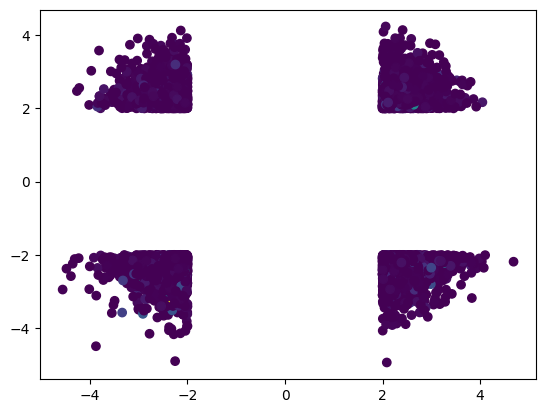

In [9]:
%%time
kde = sp.gaussian_kde(dist.T)
plt.scatter(dist[:,0], dist[:,1], c = kde(dist.T));

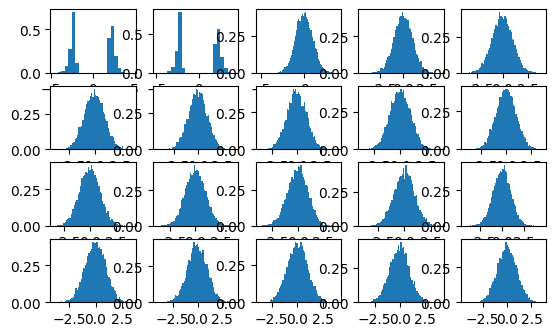

In [5]:
for i in range(d):
    plt.subplot(5,5,i+1)
    plt.hist(dist[:, i],bins= 'auto', density=True);

In [ ]:
mixture = MoGPrior(2, 16)
z = mixture(tf.constant(5))
w = tf.nn.softmax(mixture.w, axis = 1)
z = tf.expand_dims(z, axis=0)
means = mixture.means
means = tf.expand_dims(means, axis=1)
logvar = tf.expand_dims(mixture.logvars, axis=1)
nn_exp = -0.5*(tf.math.log(2.0*np.pi) + logvar)
exp_ = -0.5*(z - means)**2 * (tf.exp(-logvar))
tf.reduce_sum(exp_ + nn_exp, axis=-1)
tf.reduce_logsumexp(tf.reduce_sum(exp_ + nn_exp, axis=-1) + tf.math.log(w), axis=0)
mixture.log_prob(z)

In [32]:
encoder = Encoder(d,2)
decoder = Decoder(d,2)
mixture = MoGPrior(2,16)
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.005))
history = vae.fit(dist,epochs=100,
    batch_size=200,
    shuffle=True)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 0.2336 - loss: 13.2393 - reconstruction_loss: 13.0057
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.1024 - loss: 11.9095 - reconstruction_loss: 11.8070
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - kl_loss: 0.0862 - loss: 11.8382 - reconstruction_loss: 11.7521
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.0945 - loss: 11.8586 - reconstruction_loss: 11.7641
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - kl_loss: 0.0661 - loss: 11.8143 - reconstruction_loss: 11.7482
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - kl_loss: 0.0732 - loss: 11.8435 - reconstruction_loss: 11.7703
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.0628 - loss: 11.8378 - reconstruction_loss: 11.7749
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - kl_loss: 0.0935 - loss: 11.8888 - reconstruction_loss: 11.7953
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0863 - l

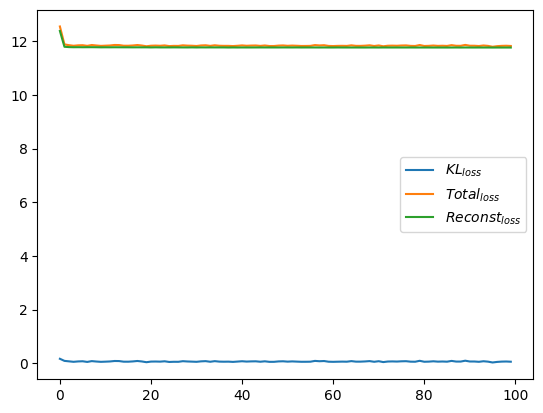

In [7]:
plt.plot(history.history['kl_loss'], label = r'$KL_{loss}$')
plt.plot(history.history['loss'], label = r'$Total_{loss}$')
plt.plot(history.history['reconstruction_loss'], label = r'$Reconst_{loss}$')
plt.legend()

In [33]:
vae.trainable_variables

[<KerasVariable shape=(20, 20), dtype=float32, path=vae/encoder/dense_12/kernel>,
 <KerasVariable shape=(20,), dtype=float32, path=vae/encoder/dense_12/bias>,
 <KerasVariable shape=(20, 64), dtype=float32, path=vae/encoder/dense_13/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=vae/encoder/dense_13/bias>,
 <KerasVariable shape=(64, 32), dtype=float32, path=vae/encoder/dense_14/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=vae/encoder/dense_14/bias>,
 <KerasVariable shape=(32, 2), dtype=float32, path=vae/encoder/z_mean/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/encoder/z_mean/bias>,
 <KerasVariable shape=(32, 2), dtype=float32, path=vae/encoder/z_log_var/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/encoder/z_log_var/bias>,
 <KerasVariable shape=(2, 2), dtype=float32, path=vae/decoder/dense_15/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/decoder/dense_15/bias>,
 <KerasVariable shape=(2, 32), dtype=float32, path=vae/

In [25]:
class Variable_training(layers.Layer):
    def __init__(self, num_components, latent_dim, **kwargs):
        super(Variable_training, self).__init__( name = 'variables', **kwargs)
        self.n_components = num_components
        self.latent_dim = latent_dim

        self.means = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)), name = 'means', trainable=True)
        self.logvars = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)), name = 'logvars', trainable=True)
        self.w = layers.Dense(64, activation='relu', name ='dense')
    def call(self):
        return self.means, self.logvars, self.w

In [26]:
var_training = Variable_training(3, 2)
var_training.trainable_variables

[]

In [31]:
vae = VAE(encoder, decoder, mixture)
vae.trainable_weights

[<KerasVariable shape=(2, 2), dtype=float32, path=vae/decoder/dense_3/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=vae/decoder/dense_3/bias>,
 <KerasVariable shape=(2, 32), dtype=float32, path=vae/decoder/dense_4/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=vae/decoder/dense_4/bias>,
 <KerasVariable shape=(32, 64), dtype=float32, path=vae/decoder/dense_5/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=vae/decoder/dense_5/bias>,
 <KerasVariable shape=(64, 20), dtype=float32, path=vae/decoder/x_out/kernel>,
 <KerasVariable shape=(20,), dtype=float32, path=vae/decoder/x_out/bias>,
 <KerasVariable shape=(64, 20), dtype=float32, path=vae/decoder/x_log_var/kernel>,
 <KerasVariable shape=(20,), dtype=float32, path=vae/decoder/x_log_var/bias>]

In [13]:
mixture = vae.prior
mixture.non_trainable_weights

[]

In [17]:
_,_, z = encoder(dist)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it 

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

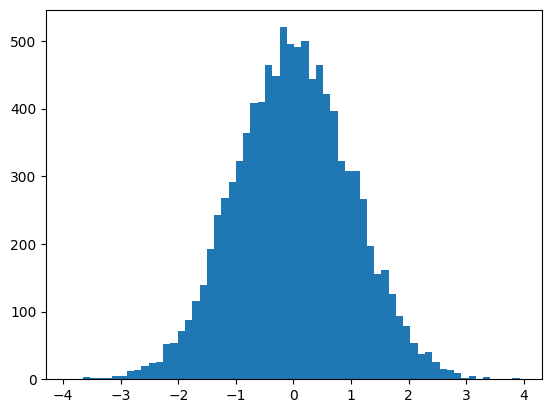

In [20]:
plt.hist(sample[:, 5], bins='auto');

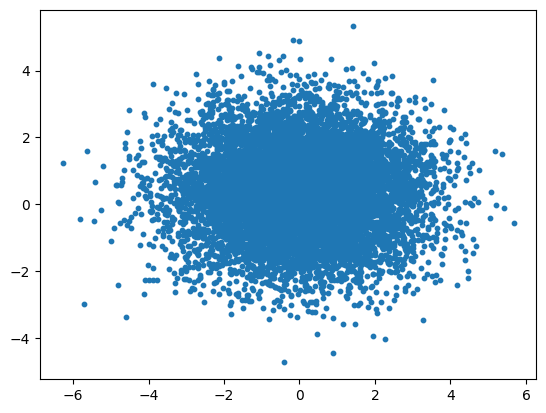

In [21]:
plt.scatter(z[:, 0], z[:, 1], s = 10)

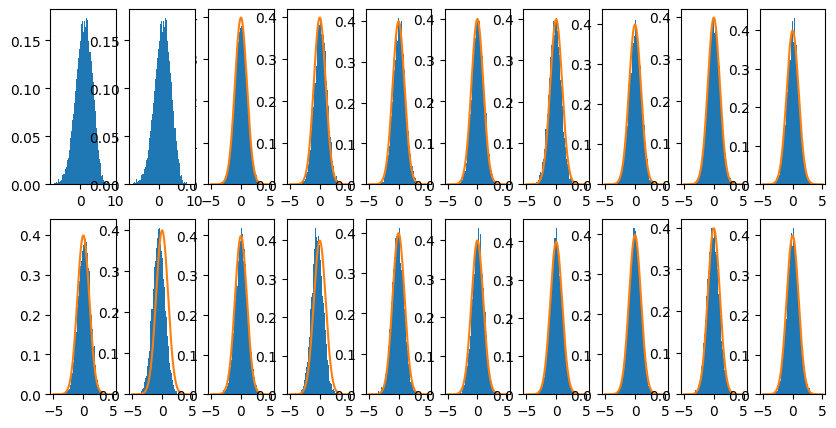

In [13]:
plt.figure(figsize=(10,5))
col = int(d/2)
xx = np.linspace(-5,5, 1000)
distr1 = ot.TruncatedDistribution(ot.Normal(1), 2, ot.TruncatedDistribution.LOWER)
distr2 = ot.TruncatedDistribution(ot.Normal(1), 2, ot.TruncatedDistribution.LOWER)
for i in range(2,d):
    plt.subplot(2, col, i+1)
    plt.hist(sample[:,i], density=True, bins = 'auto');
    plt.plot(xx, sp.norm.pdf(xx))
plt.subplot(2, col, 1)
plt.hist(sample[:,0], density=True, bins = 'auto');
#plt.plot(xx, distr1.computePDF(xx.reshape((-1,1))))

plt.subplot(2, col, 2)
plt.hist(sample[:,0], density=True, bins = 'auto');
#plt.plot(xx, distr2.computePDF(xx.reshape((-1,1))))

In [19]:
print(f"La moyenne empirique de la  1er composante {np.mean(mean_x, axis=0)[0]} et la moyenne théorique  {sp.norm.pdf(2)/(1-sp.norm.cdf(2))}" )
print(f"Moyenne empirique {np.mean(tf.exp(log_var_x/2), axis = 0 )[0]}, moyenne théorique {np.sqrt(1 - sp.norm.pdf(2)/(1-sp.norm.cdf(2)) * (sp.norm.pdf(2)/(1-sp.norm.cdf(2)) - 2))}")

La moyenne empirique de la  1er composante 2.3693594932556152 et la moyenne théorique  2.373215532822841
Moyenne empirique 0.3409057855606079, moyenne théorique 0.33805191970181275
